In [1]:
import numpy as np
from scipy.optimize import curve_fit

from matplotlib import pyplot as plt
from scipy import stats

In [2]:
def double_gaussian(x, c1, mu1, sigma1, c2, mu2, sigma2):
    res =   c1 * np.exp( - (x - mu1)**2.0 / (2.0 * sigma1**2.0) ) \
          + c2 * np.exp( - (x - mu2)**2.0 / (2.0 * sigma2**2.0) )
    return res


def fit_double_gaussian(x, y, mean_tolerance=0.01):
    
    x0 = [
        1.0, 0.435, 0.01, 
        1.0, 0.48, 0.01
    ] 

    x_opt, _ = curve_fit(
        double_gaussian,
        x,
        y,
        p0=x0,
        bounds=[
            [0.0, x0[1] - mean_tolerance, 0.0, 0.0, x0[4] - mean_tolerance, 0.0],
            [np.inf, x0[1] + mean_tolerance, np.inf, np.inf, x0[4] + mean_tolerance, np.inf],
        ],
        maxfev=10000
    )

    return x_opt


def ratio_area_under_gaussians(params):
    
    c1, _, sigma1, c2, _, sigma2 = params
    coeff = np.sqrt(2.0 * np.pi)
    
    if c1 < 0.0 or c2 < 0.0:
        print("Warning, negative area under Gaussian")
    
    A1 = coeff * np.abs(c1) * sigma1
    A2 = coeff * np.abs(c2) * sigma2
    
    return A2 / (A1 + A2)


def ratio_gaussians_heights(params):
    
    c1, _, _, c2, _, _ = params
    
    if c1 < 0.0 or c2 < 0.0:
        print("Warning, negative area under Gaussian")
    
    A1 = np.abs(c1)
    A2 = np.abs(c2)
    
    return A2 / (A1 + A2)


def peak_height_ratio(x, y, peak_1_x, peak_2_x):
    
    a1 = y[np.argmin(np.abs(x - peak_1_x))]
    a2 = y[np.argmin(np.abs(x - peak_2_x))]

    return a1/(a1+a2)

## load data

In [3]:
all_data = {}
samples = ["native", "TCEP", "peroxide"]
sample_colors = ["k", "blue", "teal"]
sample_titles = [ "native", "+1 mM TCEP","+1 mM peroxide"]

for sample in samples:        
    all_data[sample] = np.genfromtxt('./data/{}.csv'.format(sample), delimiter=',', skip_header=2)

# shift data to account for different start times in each run
all_data["TCEP"][:,0] -= 0.14
all_data["peroxide"][:,0] += 0.15

nominal_concentrations = list([100.0 * 1.0/(2**n) for n in np.arange(8)])
print(nominal_concentrations)

[100.0, 50.0, 25.0, 12.5, 6.25, 3.125, 1.5625, 0.78125]


In [4]:
def auc_to_concentration(auc):
    """ value fixed by linear regression from calibration run """
    m = 0.00408564
    return m * auc

## sigmoid binding curves

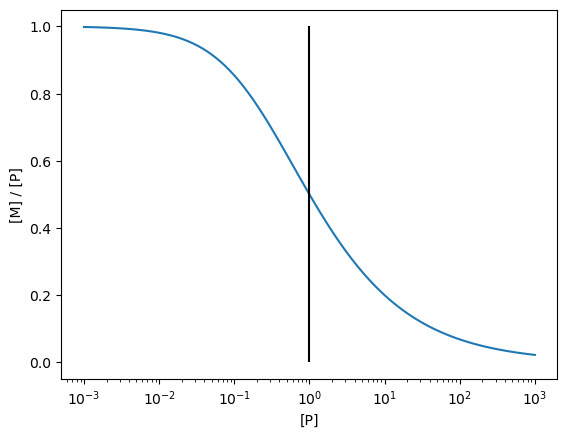

In [5]:
def r_p(p, K):
    return (np.sqrt(8*p/K + 1) - 1) / (4*p/K)

K_test = 1.0
x = np.logspace(-3, 3, 100)
y = r_p(x, K_test)

plt.figure()
plt.plot(x, y)
plt.xscale('log')
plt.vlines(K_test, 0.0, 1.0, color='k')
plt.xlabel('[P]')
plt.ylabel('[M] / [P]')
plt.show()

In [6]:
def fit_K(Ps, Rs):
    popt, pcov = curve_fit(r_p, Ps, Rs, p0=1.0)
    K = popt[0]
    sig_K = np.sqrt(pcov[0][0])
    return K, sig_K

In [7]:
# position of peaks
mu1 = 0.435
mu2 = 0.49
mu2_peroxide = 0.475

# peak positions
low_cv_cutoff = 0.405
hgh_cv_cutoff = 0.520

baseline_region_width = 100

sample          	Kd (uM)	sigK	 95% CI
------          	-------	----	--------
native          	2.33	0.27	+/- 0.63
TCEP            	2.08	0.50	+/- 1.17
peroxide        	18.83	6.28	+/- 14.84


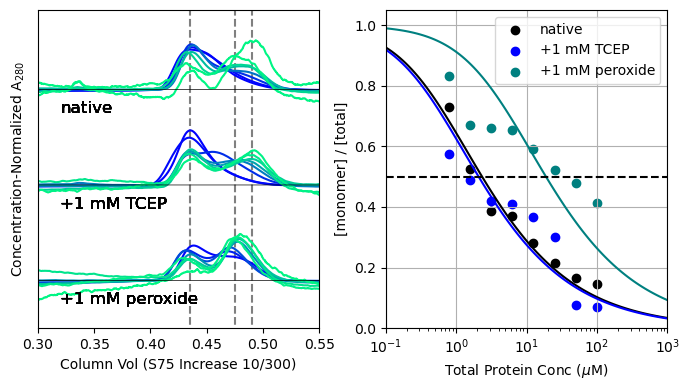

In [30]:
p_x = np.logspace(-1, 3, 100) # range to plot fits

source_data_left = {}
source_data_right = {}


plt.figure(figsize=(7,4))

print('sample          \tKd (uM)\tsigK\t 95% CI')
print('------          \t-------\t----\t--------')

axL = plt.subplot(121)
axR = plt.subplot(122)

axL.vlines([mu1, mu2, mu2_peroxide], -0.0145, 0.0025, color='grey', linestyles='dashed')

axR_legend = []

for sample_index, sample in enumerate(samples):
    
    offset = -sample_index * 0.0024
    
    data = all_data[sample]
    
    n_concs = data.shape[1] - 1
    colors = plt.cm.winter(np.logspace(0,-3,41000))
    
    CV = data[:,0] / 24.0
    
    # define the region to integrate 
    start = np.argmin(np.abs(CV - low_cv_cutoff))
    end   = np.argmin(np.abs(CV - hgh_cv_cutoff))
    
    cs = []
    rs = []
    
    for i in range(1, n_concs+1):

        baseline_segment = np.concatenate([
            data[start-baseline_region_width:start,i], 
            data[end:end+baseline_region_width,i], 
        ])
        UV = data[:,i] - np.median(baseline_segment)

        auc = UV[start:end].sum()
        #con = auc_to_concentration(auc)  # use AUC as concentration
        con = nominal_concentrations[i-1]  # use nominal concentration
        
        axL.plot(CV, UV / auc + offset, color=colors[round(auc)])
        source_data_left[(sample, con, "CV")] = CV
        source_data_left[(sample, con, "abs280")] = UV / auc
        axL.text(0.32, -6.0e-4 + offset, sample_titles[sample_index], fontsize=12)
        
        # > gaussian fit method
        # params = fit_double_gaussian(CV[start:end], UV[start:end])
        # r = ratio_area_under_gaussians(params)
        # residual = UV - double_gaussian(CV, *params)

        # > peak height method
        if sample.startswith('peroxide'):
            r = peak_height_ratio(CV, UV, mu2_peroxide, mu1)
        else:
            r = peak_height_ratio(CV, UV, mu2, mu1)

        cs.append(con)
        rs.append(r)
        
    axL.plot(CV, np.ones(len(CV)) * offset, color='k', lw=0.5)  # baseline

    p = axR.scatter(cs, rs, color=sample_colors[sample_index])
    
    # fit to model
    K, sig_K = fit_K(cs, rs)
    axR.plot(p_x, r_p(p_x, K), color=sample_colors[sample_index])
    source_data_right[(sample, "conc (uM)")] = cs
    source_data_right[(sample, "[M]/[T]")] = rs
    
    # estimate 95% CI -- though unlikely parameters are Gaussian
    interval = stats.t.interval(confidence=0.95, df=len(cs)-1, loc=K, scale=sig_K)
    print(f'{sample.ljust(16)}\t{K:.2f}\t{sig_K:.2f}\t+/- {interval[1] - K:.2f}')
    axR_legend.append(p)
        
        
axL.set_xlim([0.30, 0.55])
axL.set_ylim([-0.006, 0.002])
axL.set_yticks([])
axL.set_xlabel('Column Vol (S75 Increase 10/300)')
axL.set_ylabel('Concentration-Normalized A$_\mathrm{280}$')

axR.set_ylim([-0.0, 1.05])
axR.set_xscale('log')
axR.legend(axR_legend, sample_titles, loc=1)
axR.set_xlabel('Total Protein Conc ($\mu$M)')
axR.set_ylabel('[monomer] / [total]')
axR.grid()
axR.set_xlim(0.1, 1000)
axR.hlines(0.5, 1e-1, 1e3, 'k', linestyles='dashed')

plt.tight_layout()
plt.savefig('analytical_sec.pdf')
plt.show()

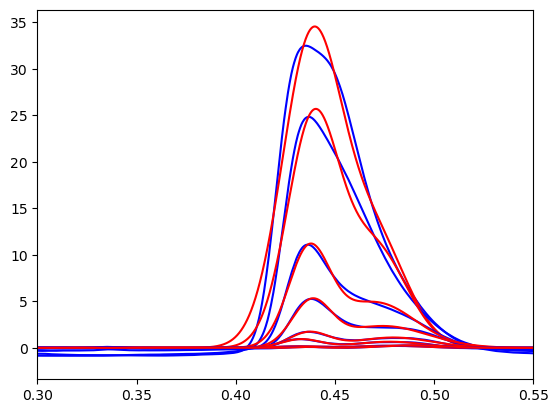

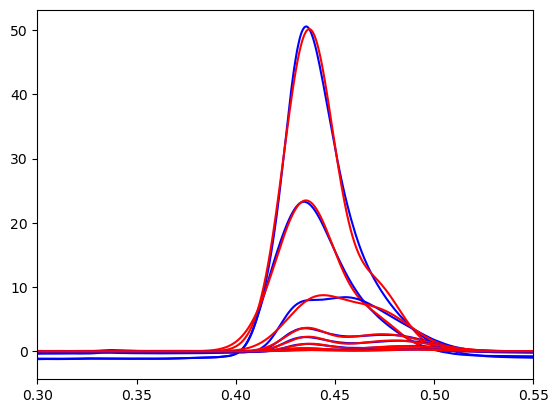

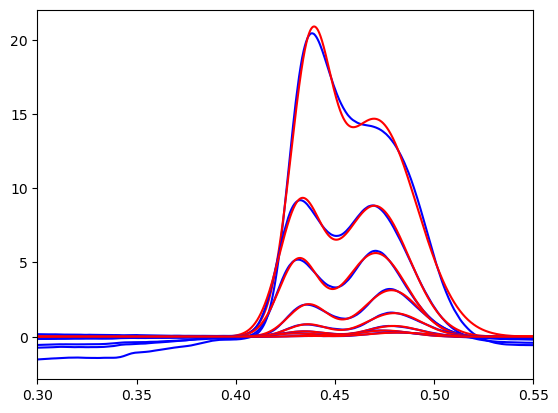

In [9]:
for sample in samples:

    plt.figure()
    ax = plt.subplot(111)

    data = all_data[sample]
    n_concs = data.shape[1] - 1
    
    CV = data[:,0] / 24.0
    
    # define the region to integrate 
    start = np.argmin(np.abs(CV - low_cv_cutoff))
    end   = np.argmin(np.abs(CV - hgh_cv_cutoff))

    for i in range(1, n_concs+1):

        baseline_segment = np.concatenate([
            data[start-20:start,i], 
            data[end:end+20,i], 
        ])
        UV = data[:,i] - np.median(baseline_segment)

        auc = UV[start:end].sum()
        con = auc_to_concentration(auc)
        
        ax.plot(CV, UV, color='b')
        params = fit_double_gaussian(CV[start:end], UV[start:end])
        ax.plot(CV, double_gaussian(CV, *params), color='red')
        ax.set_xlim([0.30, 0.55])

    plt.show()

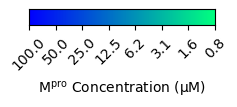

In [10]:
plt.figure(figsize=(2.4,.2))
ax = plt.subplot(111)
gradient = np.vstack((np.linspace(0, 1, 256), np.linspace(0, 1, 256)))
ax.imshow(gradient, aspect='auto', cmap=plt.cm.winter)
ax.set_yticks([])
plt.xticks(
    np.linspace(-1, 256, len(nominal_concentrations)),
    ["%.1f" % c for c in nominal_concentrations],
    rotation=45
)
ax.set_xlabel('M$^{\mathrm{pro}}$ Concentration (µM)')
plt.savefig('concentration_scale.pdf', bbox_inches='tight')
plt.show()

### save source data

In [18]:
import pandas as pd
from copy import copy

In [22]:
def zero_padded_df(source_dict):

    max_length = max([len(source_dict[k]) for k in source_dict])
    
    source_dict = copy(source_dict)
    for k in source_dict:
        source_dict[k] = pd.Series(source_dict[k]).reindex(range(max_length), fill_value=0)
    
    return pd.DataFrame(source_dict)

In [33]:
zero_padded_df(source_data_left).to_csv("source_data_SEC_traces.csv")

In [34]:
zero_padded_df(source_data_right).to_csv("source_data_monomer_fraction.csv")